In [1]:
import gc
from itertools import combinations
import os
import sys
import time
from typing import Optional
from unicodedata import bidirectional
from imblearn.over_sampling import SMOTE
import joblib
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences 
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from model.LSTM.v3.feature_engineer import FeatureEngineering as fe

In [2]:
def create_dataframe_from_data(input_path: str):
    data_frames = []
    landmark_cols = []
    landmark_world_cols = [] 
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column names
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols
    

def split_dataset(dataframe: pd.DataFrame, target_label: str, additional_targets: list=None, train_ratio=0.8, test_ratio=0.2):
    
    assert train_ratio  + test_ratio == 1.0, "Ratios must sum to 1."
    
    train_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)

        train_split = gesture_data.iloc[:n_train]
        test_split = gesture_data.iloc[n_train:]

        train_frames.append(train_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[target_label])
    y_train = train_set[[target_label] + additional_targets]
    X_test = test_set.drop(columns=[target_label])
    y_test = test_set[[target_label] + additional_targets]

    return X_train, y_train, X_test, y_test

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):

        df_copy = df.copy()

        # s = time.process_time()
        df_elapsed = fe.calculate_elapsed_time(df_copy)    
        df_temporal = fe.calculate_temporal_features(df_copy, landmark_cols)
        # df_stats = fe.calculate_temporal_stats(df_copy, landmark_cols)
        # df_pairwise = fe.calculate_landmark_distances(df_copy, landmark_cols)
        df_angle = fe.calculate_landmark_angles(df_copy, landmark_cols)
        df_combined = pd.concat([df_copy, df_angle], axis=1)
        # print(time.process_time()-s)
        
        # Ensure there are no duplicate columns
        df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
        return df_combined

def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def reshape_y_labels(df: pd.DataFrame):
    """
    reasoning for this function:
    a single gesture recording can have the same index of n frames.
    This will balloon the size of the (x, y), when in reality it's much
    smaller. This will goo through each frame, and if the continuous pattern
    breaks (e.g. 12 -> 0), everything before "12" will be removed keeping only
    one instance of the gesture
    """
    unique_sequences = []
    for _, group in df.groupby("gesture_index"):
        reset_points = group['frame'].diff().fillna(1) < 0
        if reset_points.any():
            unique_sequences.append(group[reset_points])
        else:
            # If no reset points, consider the whole group as unique
            unique_sequences.append(group.iloc[[0]])

    # Concatenate unique sequences
    df_unique = pd.concat(unique_sequences).reset_index(drop=True)
    return df_unique["gesture"]

def encode_labels(y_train_reshaped, y_test_reshaped):
    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train_reshaped, y_test_reshaped])
    label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.fit_transform(y_train_reshaped)
    y_test_encoded = label_encoder.fit_transform(y_test_reshaped)

    return label_encoder,y_train_encoded, y_test_encoded

def find_longest_continuous_chain(df: pd.DataFrame):
    gesture_index_cols = df.columns[df.columns.str.startswith("cat__gesture_index_")]

    longest_length = 0 
    target_gesture_index = None 

    for col in gesture_index_cols:
        gesture_index = col.split("_")[-1]
        gesture_data = df[col].values 

        # Use NumPy to find the lengths of continuous sequences of 1s
        padded = np.pad(gesture_data, (1, 1), constant_values=0)
        diff = np.diff(padded)
        start_indices = np.where(diff == 1)[0]
        end_indices = np.where(diff == -1)[0]
        lengths = end_indices - start_indices
        
        max_length = lengths.max() if lengths.size > 0 else 0

        if max_length > longest_length:
            longest_length = max_length
            target_gesture_index = gesture_index

    return [longest_length, target_gesture_index]

def pad_dataframe(df: pd.DataFrame, train_pad_len = None):

    frame_list = find_longest_continuous_chain(df.copy())

    cols_to_pad = [col for col in df.columns if col.startswith("cat__gesture_index_") and col != frame_list[1]]
    num_of_cols = [col for col in df.columns if col.startswith("cat__gesture_index_")]

    if train_pad_len is not None:
        frame_list[0] = train_pad_len 
        cols_to_pad = [col for col in df.columns if col.startswith("cat__gesture_index_")]
        num_of_cols = [col for col in df.columns if col.startswith("cat__gesture_index_")]

    columns = df.columns
    data = df.values 
    for col in cols_to_pad:
        col_index = df.columns.get_loc(col)
        num_frames = int(df[col].sum())
        frames_diff = frame_list[0] - num_frames

        if frames_diff > 0: 
            gesture_index_rows = np.where(data[:, col_index] == 1)[0]
            last_frame_index = gesture_index_rows[-1]
            
            # Create padding array with -1 values for all columns except the current col
            padding_data = np.full((frames_diff, data.shape[1]), -1)
            padding_data[:, col_index] = -1
            
            # Insert padding rows after the last frame of the current gesture
            data = np.insert(data, last_frame_index + 1, padding_data, axis=0)

    # Convert the NumPy array back to a DataFrame
    padded_df = pd.DataFrame(data, columns=columns).drop(columns=num_of_cols)

    # padded_df.to_csv(f"model/LSTM/v2/{time.time()}.csv", index=False)
    # return numpy arrary, number of samples, timesteps, features
    return padded_df.to_numpy(), len(num_of_cols), frame_list[0], len(padded_df.columns.values.tolist())

def create_lstm(input, output_units):

    activate = "softmax"
    loss_type = "categorical_crossentropy"
    if len(output_units) == 1:
        activate = "sigmoid"
        loss_type = "binary_crossentropy"

    model = Sequential()
    model.add(Masking(mask_value=-1))
    model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=input[1:], kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(0.01)))
    model.add(LSTM(128, return_sequences=True, activation="relu"))
    model.add(LSTM(32, activation="relu"))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(units=len(np.unique(output_units)), activation=activate,  kernel_regularizer=L1L2(0.0001), bias_regularizer=L2(0.001)))
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_type, metrics=['accuracy'])
    return model

init: (1707, 133) (434, 133) (1707, 3) (434, 3)
before lstm: (17, 147, 344) (17, 147, 344) (17, 1) (17, 1)


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9231 - loss: 1.6269 - val_accuracy: 1.0000 - val_loss: 0.8476 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 1.0000 - loss: 0.7671 - val_accuracy: 1.0000 - val_loss: 0.8147 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6923 - loss: 10.7859 - val_accuracy: 1.0000 - val_loss: 0.8208 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9231 - loss: 1.5153 - val_accuracy: 1.0000 - val_loss: 0.8120 - learning_rate: 1.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 1.0000 - loss: 0.8141 - val_accuracy: 1.0000 - val_loss: 0.8168 - learning_rate: 1.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8462 - loss: 2.8684 - val_accuracy: 1.0000 - val_loss: 0.8232 - learning_rate: 1.0000e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8462 - 

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3636 - loss: 311.5190 - val_accuracy: 0.0000e+00 - val_loss: 4970.5498 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.2045 - loss: 21.6446 - val_accuracy: 0.0000e+00 - val_loss: 6263.4980 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.4545 - loss: 77.6301 - val_accuracy: 0.0000e+00 - val_loss: 2879.6694 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.2727 - loss: 171.5944 - val_accuracy: 0.0000e+00 - val_loss: 6619.1348 - learning_rate: 1.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3864 - loss: 161.2901 - val_accuracy: 0.0000e+00 - val_loss: 4748.1885 - learning_rate: 1.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.4091 - loss: 123.8009 - val_accuracy: 0.0000e+00 - val_loss: 8758.9502 - learning_rate: 5.0000e-05
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0000e+00 - loss: 50.1688 - val_accuracy: 0.6875 - val_loss: 57.1266 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.0000e+00 - loss: 59.9933 - val_accuracy: 0.6875 - val_loss: 21.1385 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.0000e+00 - loss: 15.7192 - val_accuracy: 0.6875 - val_loss: 31.3389 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.0161 - loss: 20.2005 - val_accuracy: 0.6875 - val_loss: 14.0667 - learning_rate: 1.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.0000e+00 - loss: 7.3952 - val_accuracy: 0.6875 - val_loss: 15.6869 - learning_rate: 1.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.0000e+00 - loss: 8.1251 - val_accuracy: 0.6875 - val_loss: 33.7013 - learning_rate: 1.0000e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - ac

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3333 - loss: 169.7093 - val_accuracy: 0.0526 - val_loss: 382.0992 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.2400 - loss: 132.7738 - val_accuracy: 0.0526 - val_loss: 397.6872 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.3067 - loss: 141.4211 - val_accuracy: 0.0526 - val_loss: 450.8942 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.2400 - loss: 157.8138 - val_accuracy: 0.0000e+00 - val_loss: 349.0451 - learning_rate: 5.0000e-05
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.2800 - loss: 186.7402 - val_accuracy: 0.0000e+00 - val_loss: 338.8712 - learning_rate: 5.0000e-05
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3467 - loss: 129.8568 - val_accuracy: 0.0000e+00 - val_loss: 340.2038 - learning_rate: 5.0000e-05
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/ste

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.1481 - loss: 170.3693 - val_accuracy: 0.1111 - val_loss: 22.2814 - learning_rate: 1.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1944 - loss: 188.6648 - val_accuracy: 0.0370 - val_loss: 351.7372 - learning_rate: 1.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 563.0276 - val_accuracy: 0.0370 - val_loss: 245.2399 - learning_rate: 1.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 220.3737 - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2407 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2407 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 2.5000e-05
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2407 - loss: nan - val_acc

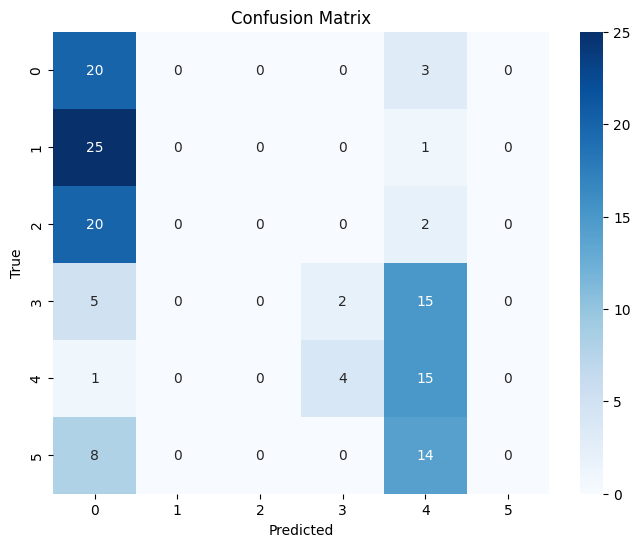

Average CV Accuracy: 0.35438415259122846 || Average CV Loss: 16.109019708633422


In [4]:
def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_2"
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    numerical_columns = ["frame_rate","frame_width","frame_height"]
    categorical_columns = ['hand', 'gesture_index']
    derived_features = ['elapsed_time'] + \
                [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_cols] + \
                [f"angle_{n1}" for n1 in range(21)] + \
                ["score"]
                # [f"lm_distance_{i}_{j}" for i in range(len(landmark_cols)//3) for j in range(len(landmark_cols)//3)] + \
    timeseries_columns = landmark_cols + landmark_world_cols + derived_features
    
    tensorboard = TensorBoard(log_dir='./model/LSTM/v3/logs')	
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)	
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8)	
    cv_accuracies = []
    cv_losses = []

    n_splits = 5
    for i in range(1, n_splits+1):

        split_df = dataframe.iloc[:int(len(dataframe)*(i/n_splits))]
        X_train, y_train, X_test, y_test = split_dataset(split_df, "gesture", ["frame", "gesture_index"])
        
        print("init:",X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        # just like how we fit_transform only on X_train, same is applied to feature engineering
        X_train_fe = calculate_hand_motion_features(X_train, landmark_cols)
        X_test_fe = calculate_hand_motion_features(X_test, landmark_cols)

        # print("feature added:",X_train_fe.shape, X_test_fe.shape, y_train.shape, y_test.shape)

        preprocessor = preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns)
        X_train_transformed = preprocessor.fit_transform(X_train_fe)
        X_test_transformed = preprocessor.transform(X_test_fe)

        y_train_reshaped = reshape_y_labels(y_train)
        y_test_reshaped = reshape_y_labels(y_test)
        
        y_train_encoded, labels = pd.factorize(y_train_reshaped)
        y_test_encoded, _ = pd.factorize(y_test_reshaped)
        y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(labels))
        y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(labels))

        # _, y_train_encoded, y_test_encoded = encode_labels(y_train_reshaped, y_test_reshaped)

        # print("preprocessed:",X_train_transformed.shape, X_test_transformed.shape, y_train_one_hot.shape, y_test_one_hot.shape)

        X_train_padded, batch_size1, steps_len1, num_features = pad_dataframe(X_train_transformed)
        X_test_padded, batch_size3, steps_len3, num_features3 = pad_dataframe(X_test_transformed, steps_len1)

        # print("padded:",X_train_padded.shape, X_test_padded.shape, y_train_one_hot.shape, y_test_one_hot.shape)

        X_train_reshaped = np.reshape(X_train_padded, (batch_size1, steps_len1, num_features))
        X_test_reshaped = np.reshape(X_test_padded, (batch_size3, steps_len3, num_features3))

        print("before lstm:",X_train_reshaped.shape, X_test_reshaped.shape, y_train_one_hot.shape, y_test_one_hot.shape)

        input = (X_train_reshaped.shape[0], X_train_reshaped.shape[1], X_train_reshaped.shape[2])
        model = create_lstm(input, labels)
        history = model.fit(
            X_train_reshaped, y_train_one_hot, 
            epochs=300, 
            batch_size=batch_size1, 
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr, tensorboard],
            )

        test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_one_hot)	
        print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

        cv_losses.append(test_loss)
        cv_accuracies.append(test_acc)

    y_pred = model.predict(X_test_reshaped)
    y_test_labels = np.argmax(y_test_one_hot, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
    print("cm_matrix:\n", cm)
   

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.ion()
    plt.show()

    print(f'Average CV Accuracy: {np.nanmean(cv_accuracies)} || Average CV Loss: {np.nanmean(cv_losses)}')

gc.collect()
main()
